In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects
import seaborn as sns
import numpy as np
import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator
import math
import os

import sys

sys.path.append('./../src/')
# from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
# mpl.rcParams['font.sans-serif'] = "Arial"
# mpl.rcParams["font.family"] = "sans-serif"


import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [3]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '11_covid_excess_days'    # name of notebook

In [4]:
def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}.pdf',
    )

In [5]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_220908_1554.csv.gz'), 
    index_col=0)

In [6]:
# Simplify discharge
data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

# Set discharge disposition order
data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

In [7]:
DISCHARGE_STACKS = [
    ('Home', 'Rehab', 'SNF', 'LTACH'),
    ('Hospice', 'Died')
]

In [8]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

## 2.8 Number of days spent in cluster

In [9]:
pt_lengths = data.groupby(["patient"]).agg({"day": "count"})

In [10]:
df = data.groupby(["patient", "Discharge_disposition", "COVID_status", "cluster"]).apply(
    lambda x: x.day.shape[0]
).reset_index()
df.rename({0: "n_days"}, axis=1, inplace=True)

In [11]:
stat_results = []
for c in df.cluster.unique():
    days1 = df.n_days[~df.COVID_status & (df.cluster == c)]
    days2 = df.n_days[df.COVID_status & (df.cluster == c)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["cluster", c, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [12]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [13]:
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append(((r.value, r.group1), (r.value, r.group2)))

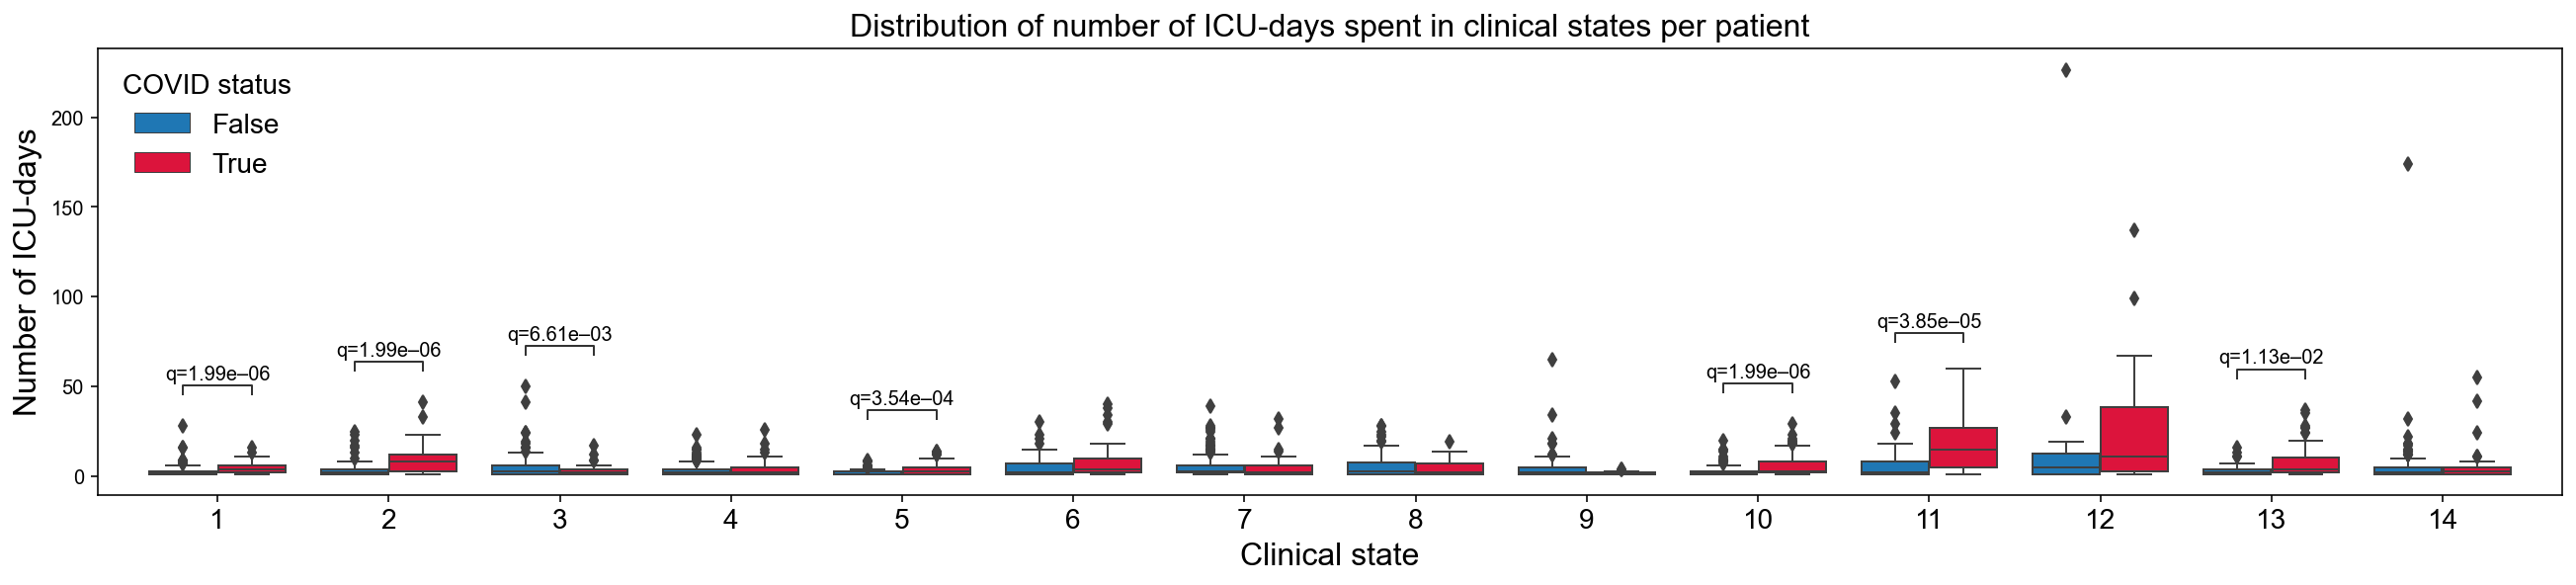

In [14]:
fig, ax = plt.subplots(figsize=(18, 4), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, 
    labels, 
    title="COVID status", 
    fontsize=14, 
    title_fontsize=14, 
    frameon=False,
    loc="upper left"
)
ax.tick_params(axis="x", labelsize=14)
ax.set_xlabel("Clinical state", size=16)
ax.set_ylabel("Number of ICU-days", size=16)
ax.set_title("Distribution of number of ICU-days spent in clinical states per patient", size=16);
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()

dump_figure('n-days-per-cluster')



# fig.savefig("13plots/13-05n-days-per-cluster.pdf")

I can think of only the average analysis for LOS specific to clusters in COVID vs non-COVID groups:

1. On average, patient with COVID has `X` LOS and patient without COVID has `Y` LOS
2. On average, patient with COVID spends `A` days in cluster `Z`
3. On average, patient without COVID spends `B` days in cluster `Z`
4. `(A - B) / (X - Y)` = fraction of days patient with COVID will spend in cluster `Z` of all extra days, on average

In [15]:
def cluster_excess_days(cluster):
    patient_los = df.groupby(["patient", "COVID_status"]).n_days.sum().reset_index().set_index("patient")
    patient_cluster_los = df.loc[df.cluster.eq(cluster)].groupby(
        ["patient", "COVID_status"]
    ).n_days.sum().reset_index().set_index("patient")
    patient_cluster_los = patient_cluster_los.reindex(patient_los.index)
    patient_cluster_los.COVID_status = patient_los.COVID_status
    # fill with 0 days for patients who didn't spend time in cluster
    patient_cluster_los.n_days.fillna(0, inplace=True)
    a = patient_cluster_los.n_days[patient_cluster_los.COVID_status].mean()
    b = patient_cluster_los.n_days[~patient_cluster_los.COVID_status].mean()
    x = patient_los.n_days[patient_los.COVID_status].mean()
    y = patient_los.n_days[~patient_los.COVID_status].mean()
    return (a - b) / (x - y)

In [16]:
for c in sorted(data.cluster.unique()):
    excess = cluster_excess_days(c)
    print(f"Fraction of excess days in cluster {c} for COVID: {excess * 100:.2f}%")

Fraction of excess days in cluster 1 for COVID: 8.86%
Fraction of excess days in cluster 2 for COVID: 12.49%
Fraction of excess days in cluster 3 for COVID: -9.33%
Fraction of excess days in cluster 4 for COVID: 2.73%
Fraction of excess days in cluster 5 for COVID: 14.87%
Fraction of excess days in cluster 6 for COVID: 16.99%
Fraction of excess days in cluster 7 for COVID: -11.72%
Fraction of excess days in cluster 8 for COVID: -3.47%
Fraction of excess days in cluster 9 for COVID: -6.76%
Fraction of excess days in cluster 10 for COVID: 17.85%
Fraction of excess days in cluster 11 for COVID: 29.89%
Fraction of excess days in cluster 12 for COVID: 12.27%
Fraction of excess days in cluster 13 for COVID: 19.95%
Fraction of excess days in cluster 14 for COVID: -4.61%


In [17]:
patient_los = df.groupby(["patient", "COVID_status"]).n_days.sum().reset_index().set_index("patient")

LOS for COVID:

In [18]:
patient_los.n_days[patient_los.COVID_status].describe()

count    190.000000
mean      30.647368
std       25.372294
min        4.000000
25%       15.000000
50%       25.000000
75%       37.750000
max      157.000000
Name: n_days, dtype: float64

LOS for non-COVID:

In [19]:
patient_los.n_days[~patient_los.COVID_status].describe()

count    395.000000
mean      16.891139
std       20.140390
min        2.000000
25%        6.000000
50%       11.000000
75%       21.000000
max      245.000000
Name: n_days, dtype: float64